In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from datetime import datetime, time
import shap

c:\Users\Azadeh\anaconda3\lib\site-packages\dask\config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
flights = pd.read_csv('../data/cleaned_flights_data.csv')

Columns (4,5,22,23,24,25,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
flights.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,AIRPORT_DESTINATION,CITY_DESTINATION,STATE_DESTINATION,COUNTRY_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,Delay,DELAY_REASON
0,1,1,4,AS,ANC,SEA,00:05:00,23:54:00,-11.0,21.0,...,61.17432,-149.99619,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,-33.0,No Delay
1,1,1,4,AA,LAX,PBI,00:10:00,00:02:00,-8.0,12.0,...,33.94254,-118.40807,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559,-17.0,No Delay
2,1,1,4,US,SFO,CLT,00:20:00,00:18:00,-2.0,16.0,...,37.61900,-122.37484,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,3.0,ARRIVAL_DELAY
3,1,1,4,AA,LAX,MIA,00:20:00,00:15:00,-5.0,15.0,...,33.94254,-118.40807,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,-14.0,No Delay
4,1,1,4,AS,SEA,ANC,00:25:00,00:24:00,-1.0,11.0,...,47.44898,-122.30931,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,-22.0,No Delay


In [4]:
flights['CANCELLED'].unique()

array([0, 1], dtype=int64)

In [5]:
flights_delay = flights[flights['CANCELLED'] == 0]

In [6]:
flights_delay.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE_x', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIRLINE_y', 'AIRPORT_ORIGIN', 'CITY_ORIGIN', 'STATE_ORIGIN',
       'COUNTRY_ORIGIN', 'LATITUDE_ORIGIN', 'LONGITUDE_ORIGIN',
       'AIRPORT_DESTINATION', 'CITY_DESTINATION', 'STATE_DESTINATION',
       'COUNTRY_DESTINATION', 'LATITUDE_DESTINATION', 'LONGITUDE_DESTINATION',
       'Delay', 'DELAY_REASON'],
      dtype='object')

In [7]:
flights_delay.drop(columns='AIRLINE_y', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
flights_delay.rename(columns = {'AIRLINE_x':'AIRLINE'}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
flights_delay.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIRPORT_ORIGIN', 'CITY_ORIGIN', 'STATE_ORIGIN', 'COUNTRY_ORIGIN',
       'LATITUDE_ORIGIN', 'LONGITUDE_ORIGIN', 'AIRPORT_DESTINATION',
       'CITY_DESTINATION', 'STATE_DESTINATION', 'COUNTRY_DESTINATION',
       'LATITUDE_DESTINATION', 'LONGITUDE_DESTINATION', 'Delay',
       'DELAY_REASON'],
      dtype='object')

In [10]:
flights_delay.isna().sum()

MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE                       0
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTURE_TIME                0
DEPARTURE_DELAY               0
TAXI_OUT                      0
SCHEDULED_TIME                1
ELAPSED_TIME              15187
AIR_TIME                  15187
DISTANCE                      0
TAXI_IN                    2629
SCHEDULED_ARRIVAL             2
ARRIVAL_TIME               2640
ARRIVAL_DELAY                 0
DIVERTED                      0
CANCELLED                     0
CANCELLATION_REASON           0
AIRPORT_ORIGIN           483711
CITY_ORIGIN              483711
STATE_ORIGIN             483711
COUNTRY_ORIGIN           483711
LATITUDE_ORIGIN          488283
LONGITUDE_ORIGIN         488283
AIRPORT_DESTINATION      483711
CITY_DESTINATION         483711
STATE_DESTINATION        483711
COUNTRY_DESTINATION      483711
LATITUDE

In [11]:
flights_delay[flights_delay['AIRPORT_ORIGIN'].isna()]

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,AIRPORT_DESTINATION,CITY_DESTINATION,STATE_DESTINATION,COUNTRY_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,Delay,DELAY_REASON
4385712,10,1,4,AA,14747,11298,00:05:00,00:15:00,10.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.0,DEPARTURE_DELAY
4385713,10,1,4,DL,14771,13487,00:05:00,00:16:00,11.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,DEPARTURE_DELAY
4385714,10,1,4,NK,12889,13487,00:05:00,00:00:00,-5.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.0,No Delay
4385715,10,1,4,AA,12892,13303,00:10:00,00:07:00,-3.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,ARRIVAL_DELAY
4385716,10,1,4,AA,14771,11057,00:10:00,00:08:00,-2.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.0,No Delay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871872,10,31,6,B6,11292,12478,23:59:00,00:14:00,15.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,DEPARTURE_DELAY
4871873,10,31,6,B6,12478,10732,23:59:00,23:58:00,-1.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-18.0,No Delay
4871874,10,31,6,B6,12478,14843,23:59:00,01:32:00,93.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.0,"DEPARTURE_DELAY, ARRIVAL_DELAY, AIRLINE_DELAY"
4871875,10,31,6,UA,14747,12266,23:59:00,23:53:00,-6.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-28.0,No Delay


In [12]:
flights_delay.ORIGIN_AIRPORT.unique()

array(['ANC', 'LAX', 'SFO', 'SEA', 'LAS', 'DEN', 'SLC', 'PDX', 'FAI',
       'MSP', 'PHX', 'SJU', 'PBG', 'IAG', 'PSE', 'BQN', 'ORD', 'GEG',
       'HNL', 'ONT', 'MCO', 'BOS', 'HIB', 'ABR', 'DFW', 'MKE', 'IAH',
       'BNA', 'BRO', 'VPS', 'BOI', 'BJI', 'PHL', 'SBN', 'EUG', 'IAD',
       'BUF', 'PWM', 'JFK', 'CRP', 'PIA', 'FAT', 'SMF', 'AUS', 'MCI',
       'ATL', 'JAX', 'MFR', 'IDA', 'MSN', 'DCA', 'SAT', 'CHS', 'SBA',
       'IND', 'CLE', 'GSP', 'BDL', 'RIC', 'BFL', 'OMA', 'RDM', 'FLL',
       'CID', 'TPA', 'SYR', 'ROC', 'TYR', 'LAN', 'GSO', 'EWR', 'PBI',
       'RSW', 'OAK', 'PVD', 'RNO', 'PIT', 'ABQ', 'MIA', 'BWI', 'TUL',
       'LGA', 'LIT', 'MSY', 'OKC', 'ATW', 'PNS', 'MEM', 'TYS', 'MHT',
       'SAV', 'CLT', 'GRB', 'ABE', 'JAN', 'OAJ', 'FAR', 'ERI', 'LEX',
       'CWA', 'TTN', 'RDU', 'CVG', 'BHM', 'ACY', 'DTW', 'RAP', 'TUS',
       'EAU', 'DLH', 'FSD', 'INL', 'SPI', 'CLD', 'COD', 'CMH', 'PSC',
       'CPR', 'ACV', 'DAL', 'PAH', 'MRY', 'ESC', 'ISN', 'PSP', 'CAE',
       'STL', 'BTV',

# List of Features

* Month (original)
* Day (original)
* Day of the Week (original)
* Airline (original)
* Origin Airport (original)
* Destination Airport (original)
* Scheduled Departure Time (original)
* Departure Time (original)
* Departure Delay (original)
* Taxi Out (original)
* Wheels Off (original)
* Scheduled Time (original)
* Elapsed Time (original)
* Air Time (original)
* Distance (original)
* Wheels On (original)
* Taxi In (original)
* Scheduled Arrival Time (original)
* Arrival Time (original)
* Arrival Delay (original)
* Diverted (original)
* City Origin (original)
* State Origin (original)
* Country Origin (original)
Latitude Origin (original)
Longitude Origin (original)
Airport Destination (original)
City Destination (original)
State Destination (original)
Country Destination (original)
Latitude Destination (original)
Longitude Destination (original)
Delay (original)
Delay Reason (original) -- Not know in advance



# Derived Features
* Time of Day: Derived from Scheduled Departure/Arrival times
* Day/Night Indicator: Binary feature indicating if the flight is during the day or night
* Season: Derived from the month to capture seasonal effects
* Weekend Indicator: Whether the flight is on a weekend

## Derive Time of Day Feature

In [13]:
import pandas as pd
import numpy as np

# Time of Day
def get_time_of_day(time_str):
    
    if isinstance(time_str, str):
        # Split the time string and convert the hour to an integer
        hour = int(time_str.split(':')[0])
        
        if hour < 6:
            return 'Early Morning'
        elif hour < 12:
            return 'Morning'
        elif hour < 18:
            return 'Afternoon'
        else:
            return 'Evening'
    else:
        return 'Unknown'  # Handle missing or unexpected values

    
flights_delay['SCHEDULED_DEPARTURE_TIME_OF_DAY'] = flights_delay['SCHEDULED_DEPARTURE'].apply(get_time_of_day)
flights_delay['SCHEDULED_ARRIVAL_TIME_OF_DAY'] = flights_delay['SCHEDULED_ARRIVAL'].apply(get_time_of_day)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
flights_delay[['SCHEDULED_DEPARTURE_TIME_OF_DAY','SCHEDULED_ARRIVAL_TIME_OF_DAY']].head()

,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY
0,Early Morning,Early Morning
1,Early Morning,Morning
2,Early Morning,Morning
3,Early Morning,Morning
4,Early Morning,Early Morning


# Drop these two rows as the scheduled arrival is unknown

In [15]:
flights_delay[flights_delay['SCHEDULED_ARRIVAL'].isna()]

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,AIRPORT_DESTINATION,CITY_DESTINATION,STATE_DESTINATION,COUNTRY_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,Delay,DELAY_REASON,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY
1124523,3,14,6,F9,TPA,PHL,21:35:00,23:15:00,100.0,11.0,...,Philadelphia International Airport,Philadelphia,PA,USA,39.87195,-75.24114,268.0,"DEPARTURE_DELAY, ARRIVAL_DELAY, LATE_AIRCRAFT_...",Evening,Unknown
1482599,4,5,7,OO,BIL,COD,21:49:00,22:15:00,26.0,12.0,...,Yellowstone Regional Airport,Cody,WY,USA,44.52019,-109.02380,26.0,DEPARTURE_DELAY,Evening,Unknown


In [16]:
flights_delay[flights_delay['SCHEDULED_DEPARTURE'].isna()]

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,AIRPORT_DESTINATION,CITY_DESTINATION,STATE_DESTINATION,COUNTRY_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,Delay,DELAY_REASON,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY


In [17]:
flights_delay = flights_delay.dropna(subset=['SCHEDULED_ARRIVAL'])

## Derive Day/Night Feature

In [18]:
# Day/Night Indicator
def is_day(time):
    # if isinstance(time, str):
        # Split the time string and convert the hour to an integer
    hour = int(time.split(':')[0])
    return 6 <= hour < 18
    # else:
        # return 'Unknown'  # Handle missing or unexpected values

flights_delay['DEPARTURE_DAY'] = flights_delay['SCHEDULED_DEPARTURE'].apply(is_day)
flights_delay['ARRIVAL_DAY'] = flights_delay['SCHEDULED_ARRIVAL'].apply(is_day)


In [19]:
flights_delay[['DEPARTURE_DAY','ARRIVAL_DAY']].head()

,DEPARTURE_DAY,ARRIVAL_DAY
0,False,False
1,False,True
2,False,True
3,False,True
4,False,False


## Derive Season and Weekend Features

* 6 means Saturday
* 7 means Sunday

In [20]:
# Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

flights_delay['SEASON'] = flights_delay['MONTH'].apply(get_season)

# Weekend Indicator
flights_delay['WEEKEND'] = flights_delay['DAY_OF_WEEK'].apply(lambda x: x >= 6)

# Display the dataframe
print(flights_delay)


         MONTH  DAY  DAY_OF_WEEK AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  \
0            1    1            4      AS            ANC                 SEA   
1            1    1            4      AA            LAX                 PBI   
2            1    1            4      US            SFO                 CLT   
3            1    1            4      AA            LAX                 MIA   
4            1    1            4      AS            SEA                 ANC   
...        ...  ...          ...     ...            ...                 ...   
5819074     12   31            4      B6            LAX                 BOS   
5819075     12   31            4      B6            JFK                 PSE   
5819076     12   31            4      B6            JFK                 SJU   
5819077     12   31            4      B6            MCO                 SJU   
5819078     12   31            4      B6            JFK                 BQN   

        SCHEDULED_DEPARTURE DEPARTURE_TIME  DEPARTU

In [21]:
flights_delay.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,Delay,DELAY_REASON,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY,DEPARTURE_DAY,ARRIVAL_DAY,SEASON,WEEKEND
0,1,1,4,AS,ANC,SEA,00:05:00,23:54:00,-11.0,21.0,...,47.44898,-122.30931,-33.0,No Delay,Early Morning,Early Morning,False,False,Winter,False
1,1,1,4,AA,LAX,PBI,00:10:00,00:02:00,-8.0,12.0,...,26.68316,-80.09559,-17.0,No Delay,Early Morning,Morning,False,True,Winter,False
2,1,1,4,US,SFO,CLT,00:20:00,00:18:00,-2.0,16.0,...,35.21401,-80.94313,3.0,ARRIVAL_DELAY,Early Morning,Morning,False,True,Winter,False
3,1,1,4,AA,LAX,MIA,00:20:00,00:15:00,-5.0,15.0,...,25.79325,-80.29056,-14.0,No Delay,Early Morning,Morning,False,True,Winter,False
4,1,1,4,AS,SEA,ANC,00:25:00,00:24:00,-1.0,11.0,...,61.17432,-149.99619,-22.0,No Delay,Early Morning,Early Morning,False,False,Winter,False


In [22]:
flights_delay.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIRPORT_ORIGIN', 'CITY_ORIGIN', 'STATE_ORIGIN', 'COUNTRY_ORIGIN',
       'LATITUDE_ORIGIN', 'LONGITUDE_ORIGIN', 'AIRPORT_DESTINATION',
       'CITY_DESTINATION', 'STATE_DESTINATION', 'COUNTRY_DESTINATION',
       'LATITUDE_DESTINATION', 'LONGITUDE_DESTINATION', 'Delay',
       'DELAY_REASON', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND'],
      dtype='object')

In [23]:
flights_delay['COUNTRY_DESTINATION'].unique()

array(['USA', nan], dtype=object)

In [24]:
flights_delay[~flights_delay['COUNTRY_DESTINATION'].isna()]

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,Delay,DELAY_REASON,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY,DEPARTURE_DAY,ARRIVAL_DAY,SEASON,WEEKEND
0,1,1,4,AS,ANC,SEA,00:05:00,23:54:00,-11.0,21.0,...,47.44898,-122.30931,-33.0,No Delay,Early Morning,Early Morning,False,False,Winter,False
1,1,1,4,AA,LAX,PBI,00:10:00,00:02:00,-8.0,12.0,...,26.68316,-80.09559,-17.0,No Delay,Early Morning,Morning,False,True,Winter,False
2,1,1,4,US,SFO,CLT,00:20:00,00:18:00,-2.0,16.0,...,35.21401,-80.94313,3.0,ARRIVAL_DELAY,Early Morning,Morning,False,True,Winter,False
3,1,1,4,AA,LAX,MIA,00:20:00,00:15:00,-5.0,15.0,...,25.79325,-80.29056,-14.0,No Delay,Early Morning,Morning,False,True,Winter,False
4,1,1,4,AS,SEA,ANC,00:25:00,00:24:00,-1.0,11.0,...,61.17432,-149.99619,-22.0,No Delay,Early Morning,Early Morning,False,False,Winter,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,12,31,4,B6,LAX,BOS,23:59:00,23:55:00,-4.0,22.0,...,42.36435,-71.00518,-30.0,No Delay,Evening,Morning,False,True,Winter,False
5819075,12,31,4,B6,JFK,PSE,23:59:00,23:55:00,-4.0,17.0,...,18.00830,-66.56301,-20.0,No Delay,Evening,Early Morning,False,False,Winter,False
5819076,12,31,4,B6,JFK,SJU,23:59:00,23:50:00,-9.0,17.0,...,18.43942,-66.00183,-17.0,No Delay,Evening,Early Morning,False,False,Winter,False
5819077,12,31,4,B6,MCO,SJU,23:59:00,23:53:00,-6.0,10.0,...,18.43942,-66.00183,-16.0,No Delay,Evening,Early Morning,False,False,Winter,False


In [25]:
airports_df = pd.read_csv('../raw_data/airports.csv')

In [26]:
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [27]:
airports_df[airports_df['IATA_CODE'] =='IAD']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
149,IAD,Washington Dulles International Airport,Chantilly,VA,USA,38.94453,-77.45581


In [28]:
airports_df['IATA_CODE'].unique()

array(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY',
       'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'AMA', 'ANC',
       'APN', 'ASE', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'AZO', 'BDL',
       'BET', 'BFL', 'BGM', 'BGR', 'BHM', 'BIL', 'BIS', 'BJI', 'BLI',
       'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO',
       'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE',
       'CAK', 'CDC', 'CDV', 'CEC', 'CHA', 'CHO', 'CHS', 'CID', 'CIU',
       'CLD', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'CMX', 'CNY', 'COD',
       'COS', 'COU', 'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'DAB',
       'DAL', 'DAY', 'DBQ', 'DCA', 'DEN', 'DFW', 'DHN', 'DIK', 'DLG',
       'DLH', 'DRO', 'DSM', 'DTW', 'DVL', 'EAU', 'ECP', 'EGE', 'EKO',
       'ELM', 'ELP', 'ERI', 'ESC', 'EUG', 'EVV', 'EWN', 'EWR', 'EYW',
       'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FNT', 'FSD',
       'FSM', 'FWA', 'GCC', 'GCK', 'GEG', 'GFK', 'GGG', 'GJT', 'GNV',
       'GPT', 'GRB',

Airport file only shows the major airports

In [29]:
flights_delay.DISTANCE.isna().sum()

0

In [30]:
flights_delay.DISTANCE.unique()

array([1448, 2330, 2296, ...,  876, 1100, 1672], dtype=int64)

Since there is no missing value in Distance Column, we can use that as a feature and skip the long/lat columns that have a lot of missing values.

In [31]:
flights_delay.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIRPORT_ORIGIN', 'CITY_ORIGIN', 'STATE_ORIGIN', 'COUNTRY_ORIGIN',
       'LATITUDE_ORIGIN', 'LONGITUDE_ORIGIN', 'AIRPORT_DESTINATION',
       'CITY_DESTINATION', 'STATE_DESTINATION', 'COUNTRY_DESTINATION',
       'LATITUDE_DESTINATION', 'LONGITUDE_DESTINATION', 'Delay',
       'DELAY_REASON', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND'],
      dtype='object')

In [32]:
features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_DEPARTURE_TIME_OF_DAY', 
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'DIVERTED', 'AIRPORT_ORIGIN', 'CITY_ORIGIN', 'STATE_ORIGIN',
       'COUNTRY_ORIGIN', 'AIRPORT_DESTINATION', 'CITY_DESTINATION', 'STATE_DESTINATION',
       'COUNTRY_DESTINATION', 'Delay', 'DELAY_REASON']


In [33]:
flights_delay[features].isna().sum()

MONTH                                   0
DAY                                     0
DAY_OF_WEEK                             0
AIRLINE                                 0
ORIGIN_AIRPORT                          0
DESTINATION_AIRPORT                     0
SCHEDULED_DEPARTURE                     0
DEPARTURE_TIME                          0
TAXI_OUT                                0
SCHEDULED_TIME                          1
SCHEDULED_DEPARTURE_TIME_OF_DAY         0
ELAPSED_TIME                        15186
AIR_TIME                            15186
DISTANCE                                0
DEPARTURE_DAY                           0
ARRIVAL_DAY                             0
SEASON                                  0
WEEKEND                                 0
TAXI_IN                              2628
SCHEDULED_ARRIVAL                       0
ARRIVAL_TIME                         2639
SCHEDULED_ARRIVAL_TIME_OF_DAY           0
DIVERTED                                0
AIRPORT_ORIGIN                    

In [34]:
flights_delay.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIRPORT_ORIGIN', 'CITY_ORIGIN', 'STATE_ORIGIN', 'COUNTRY_ORIGIN',
       'LATITUDE_ORIGIN', 'LONGITUDE_ORIGIN', 'AIRPORT_DESTINATION',
       'CITY_DESTINATION', 'STATE_DESTINATION', 'COUNTRY_DESTINATION',
       'LATITUDE_DESTINATION', 'LONGITUDE_DESTINATION', 'Delay',
       'DELAY_REASON', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND'],
      dtype='object')

In [35]:
time_cols = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'DEPARTURE_DAY', 'ARRIVAL_DAY',]

In [36]:
flights_delay[flights_delay['ELAPSED_TIME'].isna()][time_cols]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY,DEPARTURE_DAY,ARRIVAL_DAY
724,06:45:00,06:37:00,144.0,NaN,NaN,821,10:09:00,14:51:00,Morning,Morning,True,True
1455,07:45:00,07:42:00,176.0,NaN,NaN,984,10:41:00,15:05:00,Morning,Morning,True,True
2218,08:45:00,09:22:00,75.0,NaN,NaN,270,10:00:00,12:19:00,Morning,Morning,True,True
2526,09:02:00,08:59:00,75.0,NaN,NaN,295,10:17:00,13:19:00,Morning,Morning,True,True
2866,09:30:00,09:26:00,125.0,NaN,NaN,691,11:35:00,13:43:00,Morning,Morning,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5813860,14:05:00,19:01:00,336.0,NaN,NaN,2615,21:41:00,NaN,Afternoon,Evening,True,False
5815052,15:30:00,15:55:00,110.0,NaN,NaN,482,17:20:00,NaN,Afternoon,Afternoon,True,True
5816657,17:35:00,17:40:00,351.0,NaN,NaN,2358,20:26:00,22:16:00,Afternoon,Evening,True,False
5817342,18:30:00,18:40:00,163.0,NaN,NaN,968,21:13:00,22:50:00,Evening,Evening,False,False


# Define a function to calculate Elapsed Time in case of missing values

In [37]:
# Function to calculate elapsed time in minutes
def calculate_elapsed_time(departure, arrival):
    departure_dt = pd.Timestamp.combine(pd.Timestamp.today(), departure)
    arrival_dt = pd.Timestamp.combine(pd.Timestamp.today(), arrival)
    
    if arrival_dt < departure_dt:
        arrival_dt += pd.Timedelta(days=1)
        
    elapsed_time = (arrival_dt - departure_dt).total_seconds() / 60  # Convert seconds to minutes
    return elapsed_time

# Convert 'SCHEDULED_DEPARTURE' and 'SCHEDULED_ARRIVAL' to datetime.time objects
flights_delay['SCHEDULED_DEPARTURE'] = pd.to_datetime(flights_delay['SCHEDULED_DEPARTURE'], format='%H:%M:%S').dt.time
flights_delay['SCHEDULED_ARRIVAL'] = pd.to_datetime(flights_delay['SCHEDULED_ARRIVAL'], format='%H:%M:%S').dt.time


# Impute missing values in 'ELAPSED_TIME'
missing_elapsed_time = flights_delay['ELAPSED_TIME'].isna()
flights_delay.loc[missing_elapsed_time, 'ELAPSED_TIME'] = flights_delay[missing_elapsed_time].apply(
    lambda row: calculate_elapsed_time(row['SCHEDULED_DEPARTURE'], row['SCHEDULED_ARRIVAL']), axis=1)


In [38]:
flights_delay[flights_delay['ELAPSED_TIME'].isna()][time_cols]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY,DEPARTURE_DAY,ARRIVAL_DAY


In [39]:
flights_delay[features].isna().sum()

MONTH                                   0
DAY                                     0
DAY_OF_WEEK                             0
AIRLINE                                 0
ORIGIN_AIRPORT                          0
DESTINATION_AIRPORT                     0
SCHEDULED_DEPARTURE                     0
DEPARTURE_TIME                          0
TAXI_OUT                                0
SCHEDULED_TIME                          1
SCHEDULED_DEPARTURE_TIME_OF_DAY         0
ELAPSED_TIME                            0
AIR_TIME                            15186
DISTANCE                                0
DEPARTURE_DAY                           0
ARRIVAL_DAY                             0
SEASON                                  0
WEEKEND                                 0
TAXI_IN                              2628
SCHEDULED_ARRIVAL                       0
ARRIVAL_TIME                         2639
SCHEDULED_ARRIVAL_TIME_OF_DAY           0
DIVERTED                                0
AIRPORT_ORIGIN                    

# Air time has missing value

In [40]:
flights_delay[flights_delay['AIR_TIME'].isna()][time_cols]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY,DEPARTURE_DAY,ARRIVAL_DAY
724,06:45:00,06:37:00,144.0,204.0,NaN,821,10:09:00,14:51:00,Morning,Morning,True,True
1455,07:45:00,07:42:00,176.0,176.0,NaN,984,10:41:00,15:05:00,Morning,Morning,True,True
2218,08:45:00,09:22:00,75.0,75.0,NaN,270,10:00:00,12:19:00,Morning,Morning,True,True
2526,09:02:00,08:59:00,75.0,75.0,NaN,295,10:17:00,13:19:00,Morning,Morning,True,True
2866,09:30:00,09:26:00,125.0,125.0,NaN,691,11:35:00,13:43:00,Morning,Morning,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5813860,14:05:00,19:01:00,336.0,456.0,NaN,2615,21:41:00,NaN,Afternoon,Evening,True,False
5815052,15:30:00,15:55:00,110.0,110.0,NaN,482,17:20:00,NaN,Afternoon,Afternoon,True,True
5816657,17:35:00,17:40:00,351.0,171.0,NaN,2358,20:26:00,22:16:00,Afternoon,Evening,True,False
5817342,18:30:00,18:40:00,163.0,163.0,NaN,968,21:13:00,22:50:00,Evening,Evening,False,False


In [41]:
# Function to calculate air time
def calculate_air_time(row):
    if pd.notna(row['ELAPSED_TIME']) and pd.notna(row['TAXI_OUT']) and pd.notna(row['TAXI_IN']):
        return row['ELAPSED_TIME'] - row['TAXI_OUT'] - row['TAXI_IN']
    else:
        return np.nan

# Impute missing values in 'AIR_TIME'
flights_delay['AIR_TIME'] = (flights_delay.apply(lambda row: calculate_air_time(row) if pd.isna(row['AIR_TIME']) 
                                                 else row['AIR_TIME'], axis=1))

In [42]:
flights_delay[flights_delay['AIR_TIME'].isna()][time_cols]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY,DEPARTURE_DAY,ARRIVAL_DAY
4639,11:25:00,12:06:00,75.0,75.0,NaN,295,12:40:00,NaN,Morning,Afternoon,True,True
7281,14:10:00,17:36:00,32.0,32.0,NaN,107,14:42:00,NaN,Afternoon,Afternoon,True,True
7508,14:27:00,14:36:00,172.0,112.0,NaN,913,16:19:00,NaN,Afternoon,Afternoon,True,True
11120,18:16:00,18:40:00,128.0,188.0,NaN,737,21:24:00,NaN,Evening,Evening,False,False
17275,08:30:00,08:24:00,80.0,80.0,NaN,383,09:50:00,NaN,Morning,Morning,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5803507,19:25:00,20:33:00,115.0,235.0,NaN,758,23:20:00,NaN,Evening,Evening,False,False
5809154,08:55:00,09:05:00,105.0,105.0,NaN,482,10:40:00,NaN,Morning,Morning,True,True
5811879,11:55:00,12:09:00,95.0,95.0,NaN,482,13:30:00,NaN,Morning,Afternoon,True,True
5813860,14:05:00,19:01:00,336.0,456.0,NaN,2615,21:41:00,NaN,Afternoon,Evening,True,False


In [43]:
flights_delay[['ELAPSED_TIME','TAXI_OUT','TAXI_IN']].isna().sum()

ELAPSED_TIME       0
TAXI_OUT           0
TAXI_IN         2628
dtype: int64

In [44]:
flights_delay[flights_delay['ARRIVAL_TIME'].isna()][time_cols+['Delay']]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,SCHEDULED_DEPARTURE_TIME_OF_DAY,SCHEDULED_ARRIVAL_TIME_OF_DAY,DEPARTURE_DAY,ARRIVAL_DAY,Delay
4639,11:25:00,12:06:00,75.0,75.0,NaN,295,12:40:00,NaN,Morning,Afternoon,True,True,41.0
7281,14:10:00,17:36:00,32.0,32.0,NaN,107,14:42:00,NaN,Afternoon,Afternoon,True,True,206.0
7508,14:27:00,14:36:00,172.0,112.0,NaN,913,16:19:00,NaN,Afternoon,Afternoon,True,True,9.0
11120,18:16:00,18:40:00,128.0,188.0,NaN,737,21:24:00,NaN,Evening,Evening,False,False,24.0
17275,08:30:00,08:24:00,80.0,80.0,NaN,383,09:50:00,NaN,Morning,Morning,True,True,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803507,19:25:00,20:33:00,115.0,235.0,NaN,758,23:20:00,NaN,Evening,Evening,False,False,68.0
5809154,08:55:00,09:05:00,105.0,105.0,NaN,482,10:40:00,NaN,Morning,Morning,True,True,10.0
5811879,11:55:00,12:09:00,95.0,95.0,NaN,482,13:30:00,NaN,Morning,Afternoon,True,True,14.0
5813860,14:05:00,19:01:00,336.0,456.0,NaN,2615,21:41:00,NaN,Afternoon,Evening,True,False,296.0


In [45]:
flights_delay.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIRPORT_ORIGIN', 'CITY_ORIGIN', 'STATE_ORIGIN', 'COUNTRY_ORIGIN',
       'LATITUDE_ORIGIN', 'LONGITUDE_ORIGIN', 'AIRPORT_DESTINATION',
       'CITY_DESTINATION', 'STATE_DESTINATION', 'COUNTRY_DESTINATION',
       'LATITUDE_DESTINATION', 'LONGITUDE_DESTINATION', 'Delay',
       'DELAY_REASON', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND'],
      dtype='object')

In [46]:
flights_delay[flights_delay['ARRIVAL_TIME'].isna()][['TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'DIVERTED']]

,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DIVERTED
4639,NaN,12:40:00,NaN,1
7281,NaN,14:42:00,NaN,1
7508,NaN,16:19:00,NaN,1
11120,NaN,21:24:00,NaN,1
17275,NaN,09:50:00,NaN,1
...,...,...,...,...
5803507,NaN,23:20:00,NaN,1
5809154,NaN,10:40:00,NaN,1
5811879,NaN,13:30:00,NaN,1
5813860,NaN,21:41:00,NaN,1


Flights that were diverted have missing arrival time. Those rows will be deleted as the delay cannot be caluclated correctly with the new arrival time.

In [47]:
df = flights_delay[flights_delay['DIVERTED'] == 0][features]

In [48]:
df.isna().sum()

MONTH                                   0
DAY                                     0
DAY_OF_WEEK                             0
AIRLINE                                 0
ORIGIN_AIRPORT                          0
DESTINATION_AIRPORT                     0
SCHEDULED_DEPARTURE                     0
DEPARTURE_TIME                          0
TAXI_OUT                                0
SCHEDULED_TIME                          0
SCHEDULED_DEPARTURE_TIME_OF_DAY         0
ELAPSED_TIME                            0
AIR_TIME                                0
DISTANCE                                0
DEPARTURE_DAY                           0
ARRIVAL_DAY                             0
SEASON                                  0
WEEKEND                                 0
TAXI_IN                                 0
SCHEDULED_ARRIVAL                       0
ARRIVAL_TIME                            0
SCHEDULED_ARRIVAL_TIME_OF_DAY           0
DIVERTED                                0
AIRPORT_ORIGIN                    

In [49]:
df[df['AIRPORT_ORIGIN'].isna()]

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,...,AIRPORT_ORIGIN,CITY_ORIGIN,STATE_ORIGIN,COUNTRY_ORIGIN,AIRPORT_DESTINATION,CITY_DESTINATION,STATE_DESTINATION,COUNTRY_DESTINATION,Delay,DELAY_REASON
4385712,10,1,4,AA,14747,11298,00:05:00,00:15:00,15.0,237.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.0,DEPARTURE_DELAY
4385713,10,1,4,DL,14771,13487,00:05:00,00:16:00,14.0,213.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,DEPARTURE_DELAY
4385714,10,1,4,NK,12889,13487,00:05:00,00:00:00,15.0,177.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.0,No Delay
4385715,10,1,4,AA,12892,13303,00:10:00,00:07:00,28.0,296.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,ARRIVAL_DELAY
4385716,10,1,4,AA,14771,11057,00:10:00,00:08:00,12.0,291.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.0,No Delay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871872,10,31,6,B6,11292,12478,23:59:00,00:14:00,11.0,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,DEPARTURE_DELAY
4871873,10,31,6,B6,12478,10732,23:59:00,23:58:00,16.0,220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-18.0,No Delay
4871874,10,31,6,B6,12478,14843,23:59:00,01:32:00,18.0,223.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.0,"DEPARTURE_DELAY, ARRIVAL_DELAY, AIRLINE_DELAY"
4871875,10,31,6,UA,14747,12266,23:59:00,23:53:00,13.0,245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-28.0,No Delay


In [50]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'DIVERTED', 'AIRPORT_ORIGIN',
       'CITY_ORIGIN', 'STATE_ORIGIN', 'COUNTRY_ORIGIN', 'AIRPORT_DESTINATION',
       'CITY_DESTINATION', 'STATE_DESTINATION', 'COUNTRY_DESTINATION', 'Delay',
       'DELAY_REASON'],
      dtype='object')

In [51]:
features2 = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'Delay',
       'DELAY_REASON']

In [52]:
df[features2].isna().sum()

MONTH                              0
DAY                                0
DAY_OF_WEEK                        0
AIRLINE                            0
ORIGIN_AIRPORT                     0
DESTINATION_AIRPORT                0
SCHEDULED_DEPARTURE                0
DEPARTURE_TIME                     0
TAXI_OUT                           0
SCHEDULED_TIME                     0
SCHEDULED_DEPARTURE_TIME_OF_DAY    0
ELAPSED_TIME                       0
AIR_TIME                           0
DISTANCE                           0
DEPARTURE_DAY                      0
ARRIVAL_DAY                        0
SEASON                             0
WEEKEND                            0
TAXI_IN                            0
SCHEDULED_ARRIVAL                  0
ARRIVAL_TIME                       0
SCHEDULED_ARRIVAL_TIME_OF_DAY      0
Delay                              0
DELAY_REASON                       0
dtype: int64

In [53]:
df[features2].head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,...,DEPARTURE_DAY,ARRIVAL_DAY,SEASON,WEEKEND,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,SCHEDULED_ARRIVAL_TIME_OF_DAY,Delay,DELAY_REASON
0,1,1,4,AS,ANC,SEA,00:05:00,23:54:00,21.0,205.0,...,False,False,Winter,False,4.0,04:30:00,04:08:00,Early Morning,-33.0,No Delay
1,1,1,4,AA,LAX,PBI,00:10:00,00:02:00,12.0,280.0,...,False,True,Winter,False,4.0,07:50:00,07:41:00,Morning,-17.0,No Delay
2,1,1,4,US,SFO,CLT,00:20:00,00:18:00,16.0,286.0,...,False,True,Winter,False,11.0,08:06:00,08:11:00,Morning,3.0,ARRIVAL_DELAY
3,1,1,4,AA,LAX,MIA,00:20:00,00:15:00,15.0,285.0,...,False,True,Winter,False,8.0,08:05:00,07:56:00,Morning,-14.0,No Delay
4,1,1,4,AS,SEA,ANC,00:25:00,00:24:00,11.0,235.0,...,False,False,Winter,False,5.0,03:20:00,02:59:00,Early Morning,-22.0,No Delay


In [54]:
# Save cleaned and merged data
df[features2].to_csv('../data/flights_delay_cleaned.csv', index=False)

In [55]:
df = df[features2]

In [56]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'Delay', 'DELAY_REASON'],
      dtype='object')

In [57]:
df.describe()

,MONTH,DAY,DAY_OF_WEEK,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,Delay
count,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06,5.714007e+06
mean,6.547800e+00,1.570759e+01,3.932642e+00,1.606550e+01,1.418940e+02,1.370062e+02,1.135116e+02,8.244569e+02,7.429064e+00,2.466647e+01
std,3.397421e+00,8.774395e+00,1.985967e+00,8.882449e+00,7.531400e+01,7.421108e+01,7.223083e+01,6.086620e+02,5.618952e+00,1.104893e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.800000e+01,1.400000e+01,7.000000e+00,3.100000e+01,1.000000e+00,-1.620000e+02
25%,4.000000e+00,8.000000e+00,2.000000e+00,1.100000e+01,8.500000e+01,8.200000e+01,6.000000e+01,3.730000e+02,4.000000e+00,-1.700000e+01
50%,7.000000e+00,1.600000e+01,4.000000e+00,1.400000e+01,1.230000e+02,1.180000e+02,9.400000e+01,6.500000e+02,6.000000e+00,-7.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.900000e+01,1.740000e+02,1.680000e+02,1.440000e+02,1.065000e+03,9.000000e+00,1.400000e+01
max,1.200000e+01,3.100000e+01,7.000000e+00,2.250000e+02,7.180000e+02,7.660000e+02,6.900000e+02,4.983000e+03,2.480000e+02,5.930000e+03


In [58]:
# Encode categorical features
label_encoders = {}
categorical_features = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                        'SCHEDULED_DEPARTURE_TIME_OF_DAY', 'DEPARTURE_DAY', 
                        'ARRIVAL_DAY', 'SEASON', 'SCHEDULED_ARRIVAL_TIME_OF_DAY']

for col in categorical_features:
    df[col] = df[col].astype(str)


In [59]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,...,DEPARTURE_DAY,ARRIVAL_DAY,SEASON,WEEKEND,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,SCHEDULED_ARRIVAL_TIME_OF_DAY,Delay,DELAY_REASON
0,1,1,4,AS,ANC,SEA,00:05:00,23:54:00,21.0,205.0,...,False,False,Winter,False,4.0,04:30:00,04:08:00,Early Morning,-33.0,No Delay
1,1,1,4,AA,LAX,PBI,00:10:00,00:02:00,12.0,280.0,...,False,True,Winter,False,4.0,07:50:00,07:41:00,Morning,-17.0,No Delay
2,1,1,4,US,SFO,CLT,00:20:00,00:18:00,16.0,286.0,...,False,True,Winter,False,11.0,08:06:00,08:11:00,Morning,3.0,ARRIVAL_DELAY
3,1,1,4,AA,LAX,MIA,00:20:00,00:15:00,15.0,285.0,...,False,True,Winter,False,8.0,08:05:00,07:56:00,Morning,-14.0,No Delay
4,1,1,4,AS,SEA,ANC,00:25:00,00:24:00,11.0,235.0,...,False,False,Winter,False,5.0,03:20:00,02:59:00,Early Morning,-22.0,No Delay


In [60]:
df[['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME
0,00:05:00,23:54:00,04:30:00,04:08:00
1,00:10:00,00:02:00,07:50:00,07:41:00
2,00:20:00,00:18:00,08:06:00,08:11:00
3,00:20:00,00:15:00,08:05:00,07:56:00
4,00:25:00,00:24:00,03:20:00,02:59:00
...,...,...,...,...
5819074,23:59:00,23:55:00,08:19:00,07:53:00
5819075,23:59:00,23:55:00,04:46:00,04:30:00
5819076,23:59:00,23:50:00,04:40:00,04:32:00
5819077,23:59:00,23:53:00,03:40:00,03:30:00


In [62]:
time_columns = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']

for col in time_columns:
    print(col)
    print(type(df[col][0]))

SCHEDULED_DEPARTURE
<class 'datetime.time'>
DEPARTURE_TIME
<class 'str'>
SCHEDULED_ARRIVAL
<class 'datetime.time'>
ARRIVAL_TIME
<class 'str'>


In [63]:
# Convert time columns to the number of minutes since midnight
def time_to_minutes(time_val):
    try:
        if pd.isnull(time_val):
            return np.nan
        if isinstance(time_val, int):
            return time_val
        elif isinstance(time_val, str):
            h, m, s = map(int, time_val.split(':'))
        elif isinstance(time_val, time):
            h, m, s = time_val.hour, time_val.minute, time_val.second
        elif isinstance(time_val, datetime):
            h, m, s = time_val.time().hour, time_val.time().minute, time_val.time().second
        else:
            return np.nan
        return h * 60 + m
    except Exception as e:
        print(f"Error processing {time_val}: {e}")
        return np.nan
            

time_columns = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']
for col in time_columns:
    df[col] = df[col].apply(time_to_minutes)

In [64]:
df[time_columns]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME
0,5,1434,270,248
1,10,2,470,461
2,20,18,486,491
3,20,15,485,476
4,25,24,200,179
...,...,...,...,...
5819074,1439,1435,499,473
5819075,1439,1435,286,270
5819076,1439,1430,280,272
5819077,1439,1433,220,210


In [65]:
# Encode categorical features
label_encoders = {}
for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [66]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_DEPARTURE_TIME_OF_DAY',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DEPARTURE_DAY', 'ARRIVAL_DAY',
       'SEASON', 'WEEKEND', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'SCHEDULED_ARRIVAL_TIME_OF_DAY', 'Delay', 'DELAY_REASON'],
      dtype='object')

In [67]:
# Define features and target
X = df.drop(columns=['Delay', 'DELAY_REASON'])
y = df['Delay']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [68]:
# Specify the model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model with early stopping
model = lgb.train(
    params, 
    train_data, 
    valid_sets=[test_data], 
    num_boost_round=1000, 
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 15.6898


In [69]:
# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'LGBM RMSE: {rmse}')

LGBM RMSE: 15.689826187851256


# Model Improvement

* Grid Search
* Cross Validation

In [70]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'num_leaves': [31, 61],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'max_depth': [-1, 10, 20],
#     'n_estimators': [100, 200]
# }

# # Initialize the model
# lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse')

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Best parameters
# print("Best parameters found: ", grid_search.best_params_)

# # Best RMSE score
# print("Best RMSE score: ", grid_search.best_score_)


In [71]:
# from sklearn.model_selection import RandomizedSearchCV
# import lightgbm as lgb

# # Define the parameter grid
# param_dist = {
#     'num_leaves': [31, 61, 127],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'max_depth': [-1, 10, 20],
#     'n_estimators': [100, 200, 300],
#     'min_child_samples': [20, 50, 100],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# # Initialize the model
# lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse')

# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=1, random_state=42)

# # Fit RandomizedSearchCV
# random_search.fit(X_train, y_train)

# # Best parameters
# print("Best parameters found: ", random_search.best_params_)

# # Best RMSE score
# print("Best RMSE score: ", random_search.best_score_)

# LGBM with best params

In [72]:
# # Specify the model parameters
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.1,
#     'num_leaves': 61,
#     'max_depth': 10,
#     'n_estimators': 200
# }

# # Train the model with early stopping
# model = lgb.train(
#     params, 
#     train_data, 
#     valid_sets=[test_data], 
#     num_boost_round=1000, 
#     callbacks=[lgb.early_stopping(stopping_rounds=100)]
# )

Root Mean Squared Error: 15.689826187851256


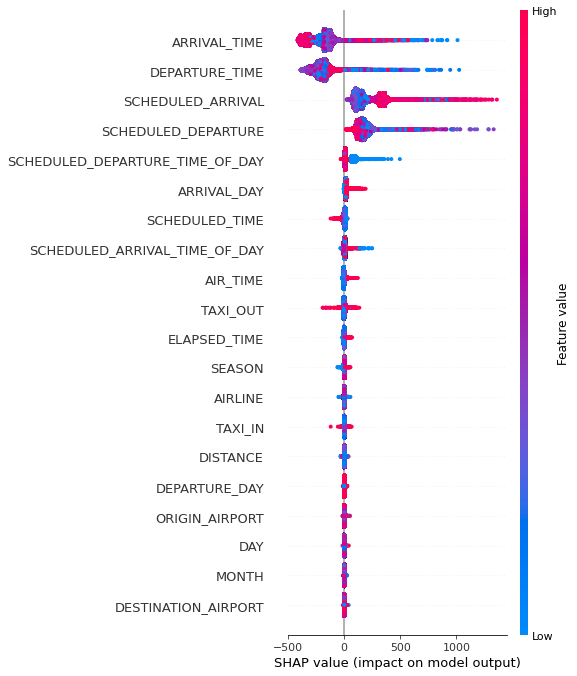

In [73]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

# Use SHAP for model interpretation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)

# Random Forest

In [74]:
# X_train.isna().sum()
# # Train Random Forest
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Make predictions
# y_pred_rf = rf_model.predict(X_test)

# # Evaluate the model
# rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
# print(f'Random Forest RMSE: {rmse_rf}')

# Train Neural Network

In [75]:
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)

# Make predictions
y_pred_nn = nn_model.predict(X_test)

# Evaluate the model
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
print(f'Neural Network RMSE: {rmse_nn}')
# Print all RMSE scores
print(f'LightGBM RMSE: {rmse}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'Neural Network RMSE: {rmse_nn}')
# Save cleaned and merged data
# df[features2].to_csv('../data/flights_delay_cleaned.csv', index=False)